<a href="https://colab.research.google.com/github/devangi2000/Deep-Learning/blob/master/Tutorial_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from IPython.display import HTML, display


def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)


def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')


def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)


def show_mat(mat, vect, prod, threshold=-1):
    # Subplot grid definition
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=True,
                                        gridspec_kw={'width_ratios':[5,1,1]})
    # Plot matrices
    cax1 = ax1.matshow(mat.numpy(), clim=(-1, 1))
    ax2.matshow(vect.numpy(), clim=(-1, 1))
    cax3 = ax3.matshow(prod.numpy(), clim=(threshold, 1))

    # Set titles
    ax1.set_title(f'A: {mat.size(0)} \u00D7 {mat.size(1)}')
    ax2.set_title(f'a^(i): {vect.numel()}')
    ax3.set_title(f'p: {prod.numel()}')

    # Remove xticks for vectors
    ax2.set_xticks(tuple())
    ax3.set_xticks(tuple())
    
    # Plot colourbars
    fig.colorbar(cax1, ax=ax2)
    fig.colorbar(cax3, ax=ax3)

    # Fix y-axis limits
    ax1.set_ylim(bottom=max(len(prod), len(vect)) - 0.5)


colors = dict(
    aqua='#8dd3c7',
    yellow='#ffffb3',
    lavender='#bebada',
    red='#fb8072',
    blue='#80b1d3',
    orange='#fdb462',
    green='#b3de69',
    pink='#fccde5',
    grey='#d9d9d9',
    violet='#bc80bd',
    unk1='#ccebc5',
    unk2='#ffed6f',
)


def _cstr(s, color='black'):
    if s == ' ':
        return f'<text style=color:#000;padding-left:10px;background-color:{color}> </text>'
    else:
        return f'<text style=color:#000;background-color:{color}>{s} </text>'

# print html
def _print_color(t):
    display(HTML(''.join([_cstr(ti, color=ci) for ti, ci in t])))

# get appropriate color for value
def _get_clr(value):
    colors = ('#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
              '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
              '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
              '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e')
    value = int((value * 100) / 5)
    if value == len(colors): value -= 1  # fixing bugs...
    return colors[value]

def _visualise_values(output_values, result_list):
    text_colours = []
    for i in range(len(output_values)):
        text = (result_list[i], _get_clr(output_values[i]))
        text_colours.append(text)
    _print_color(text_colours)

def print_colourbar():
    color_range = torch.linspace(-2.5, 2.5, 20)
    to_print = [(f'{x:.2f}', _get_clr((x+2.5)/5)) for x in color_range]
    _print_color(to_print)


# Let's only focus on the last time step for now
# First, the cell state (Long term memory)
def plot_state(data, state, b, decoder):
    actual_data = decoder(data[b, :, :].numpy())
    seq_len = len(actual_data)
    seq_len_w_pad = len(state)
    for s in range(state.size(2)):
        states = torch.sigmoid(state[:, b, s])
        _visualise_values(states[seq_len_w_pad - seq_len:], list(actual_data))

In [2]:
import torch
import torch.nn as nn
from matplotlib.pyplot import plot, title, axis

In [3]:
set_default()

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

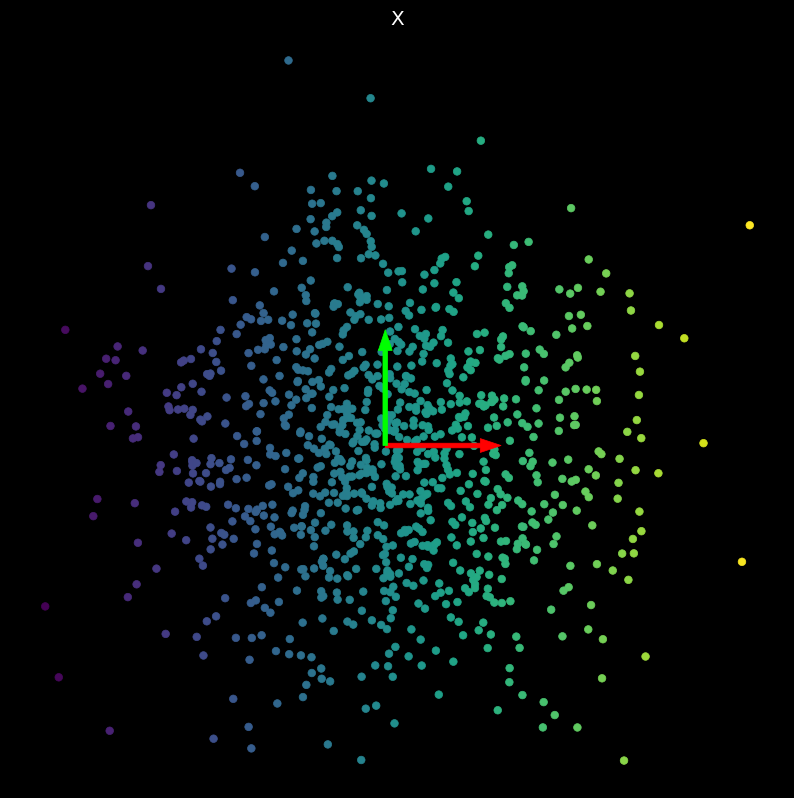

In [5]:
n_points = 1000
X = torch.randn(n_points, 2).to(device)
colors = X[:, 0]

show_scatterplot(X, colors, title= 'X')
OI = torch.cat((torch.zeros(2,2), torch.eye(2))).to(device)
plot_bases(OI)

In [6]:
torch.cat((torch.zeros(2,2), torch.eye(2)))

tensor([[0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 1.]])

# Visualizing Linear Transformations
- Generate a random matrix $W$
-
$
\begin{equation}
    W = U
  \left[ {\begin{array}{cc}
   s_1 &amp; 0 \\
   0 &amp; s_2 \\
  \end{array} } \right]
  V^\top
\end{equation}
$

- Compute $y = Wx$
- Larger singular values stretch the points
- Smaller singular values push them together
- $U, V$ rotate/reflect


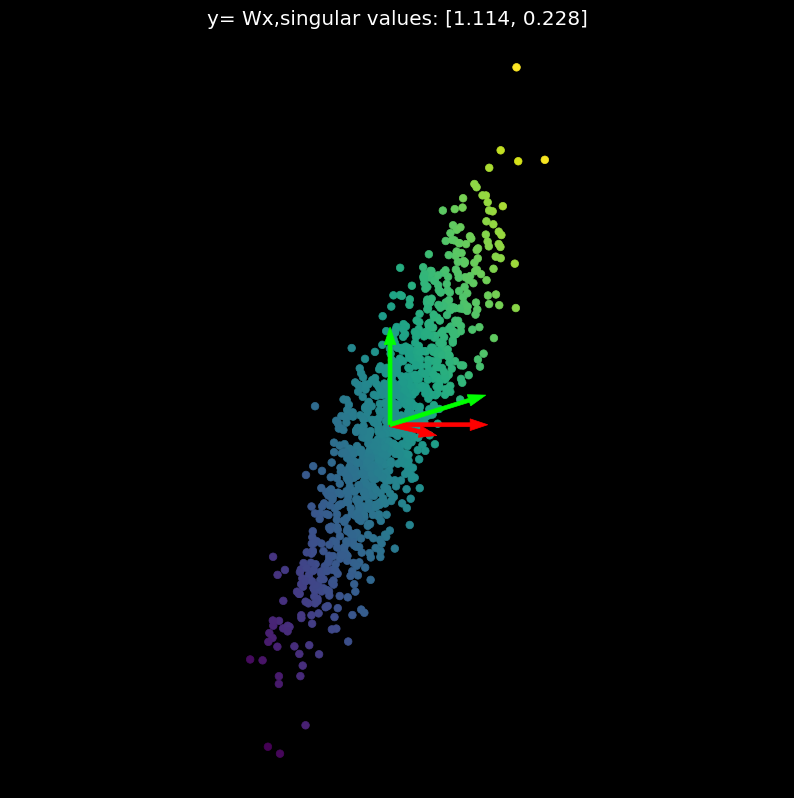

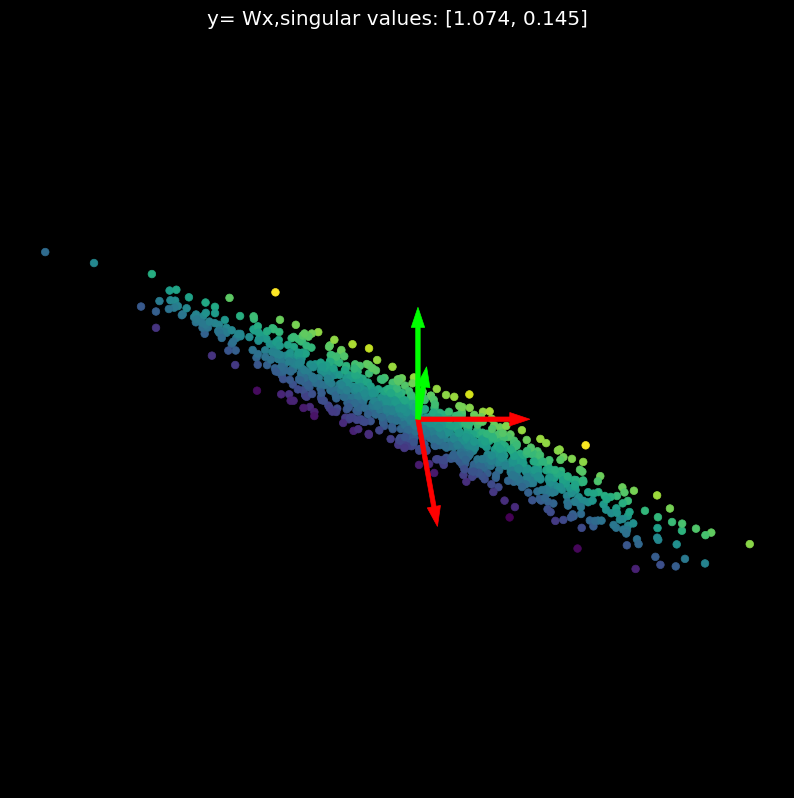

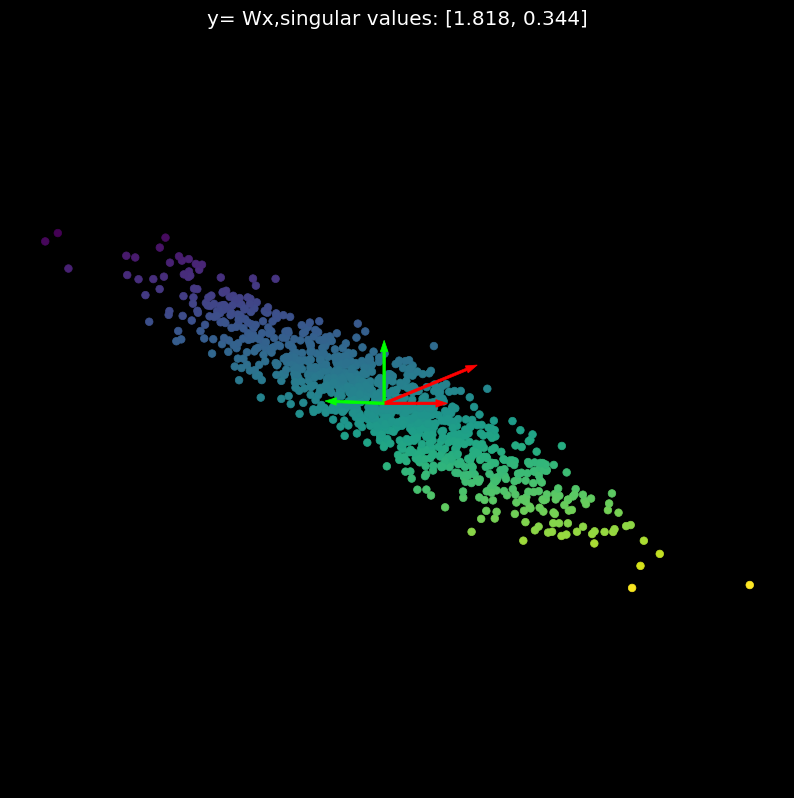

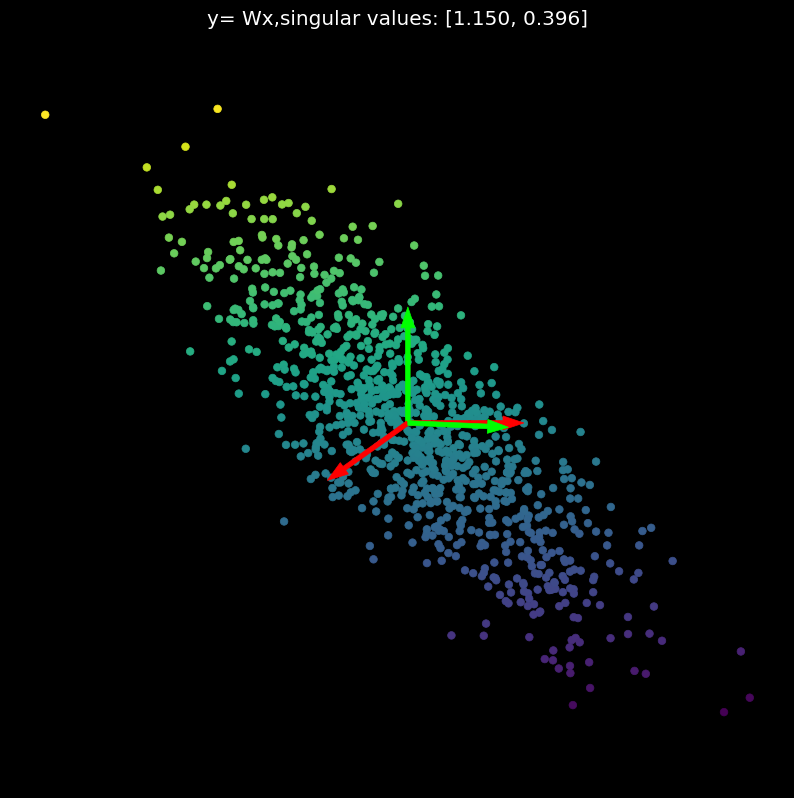

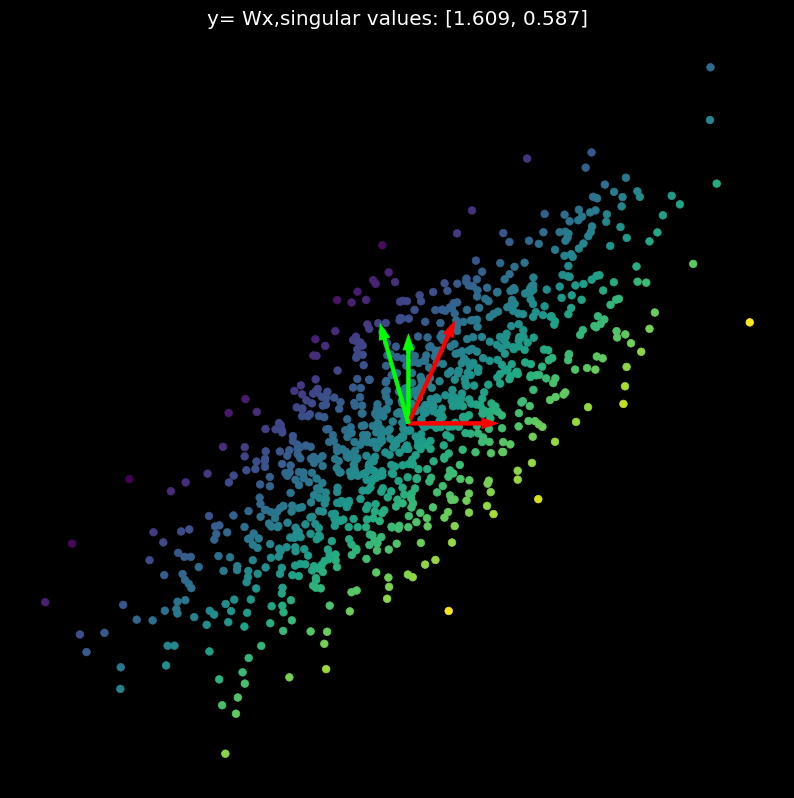

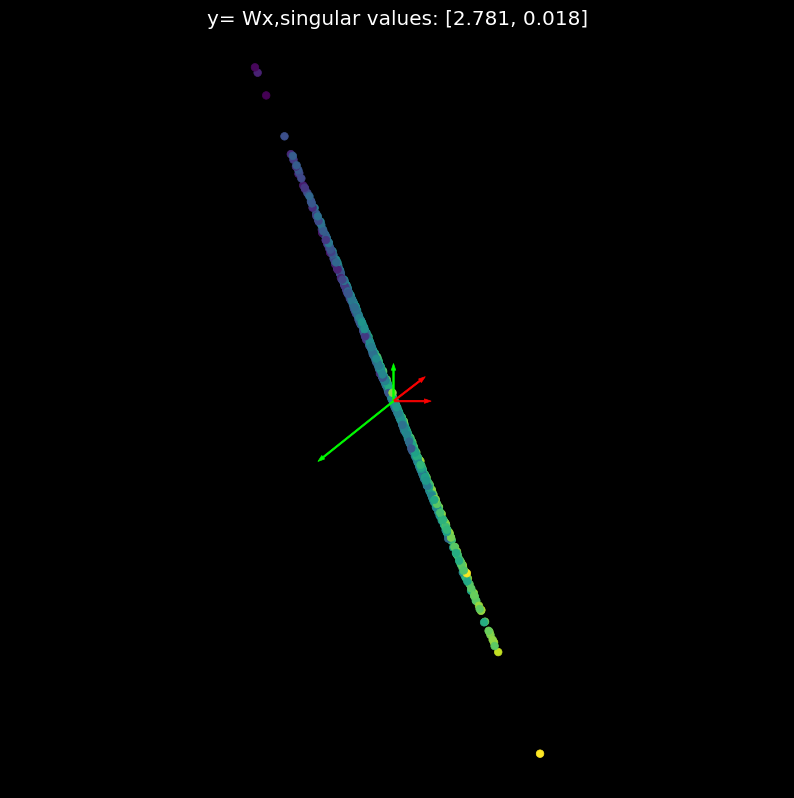

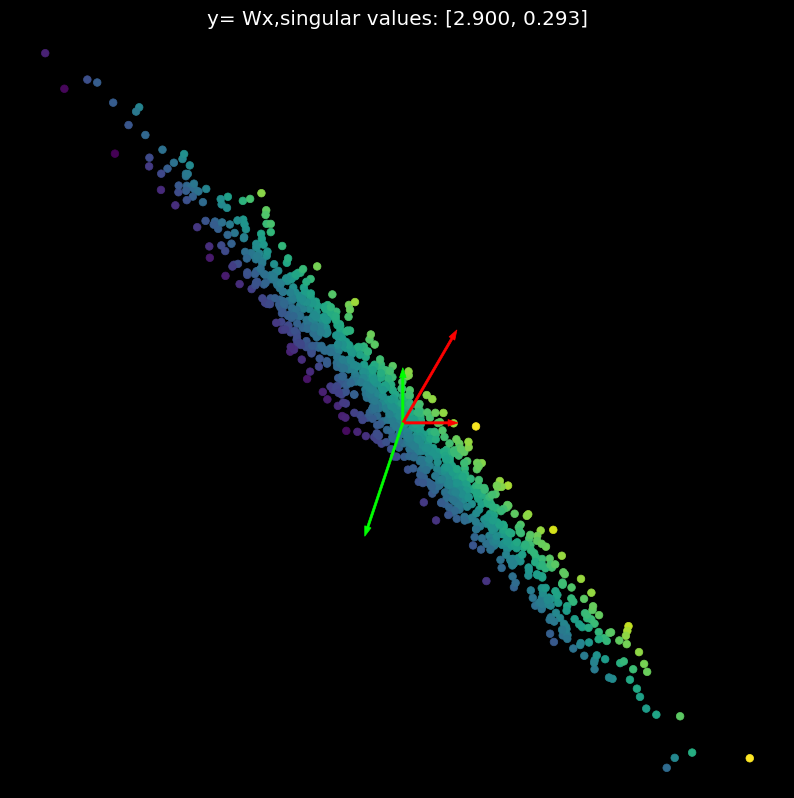

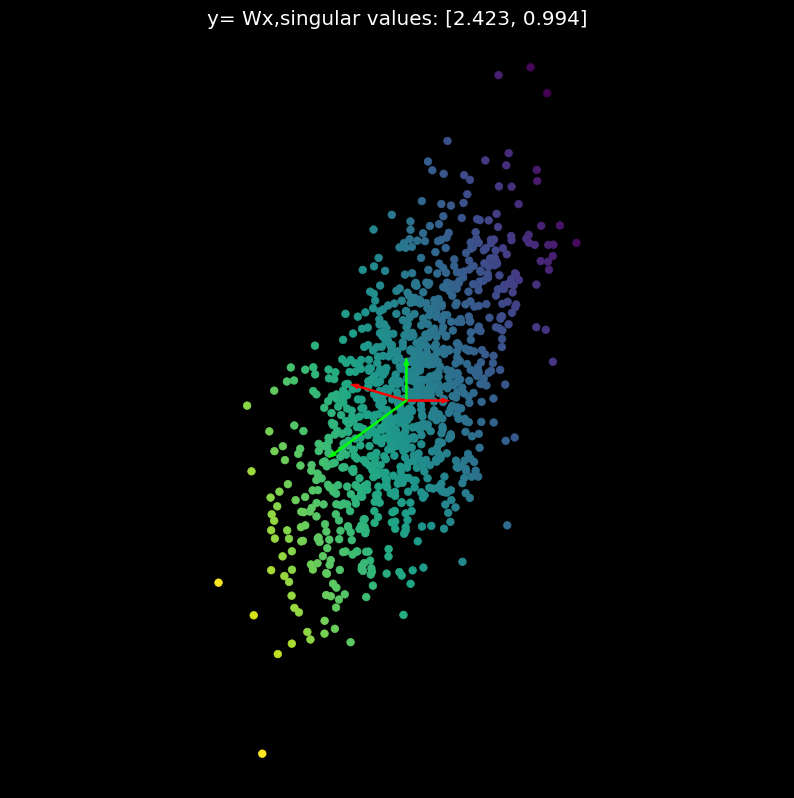

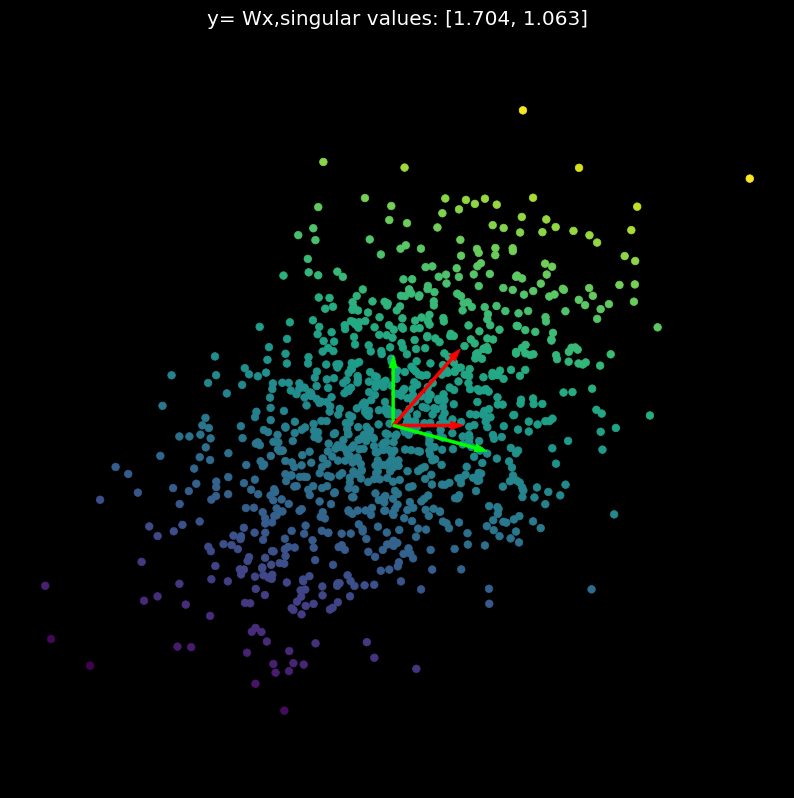

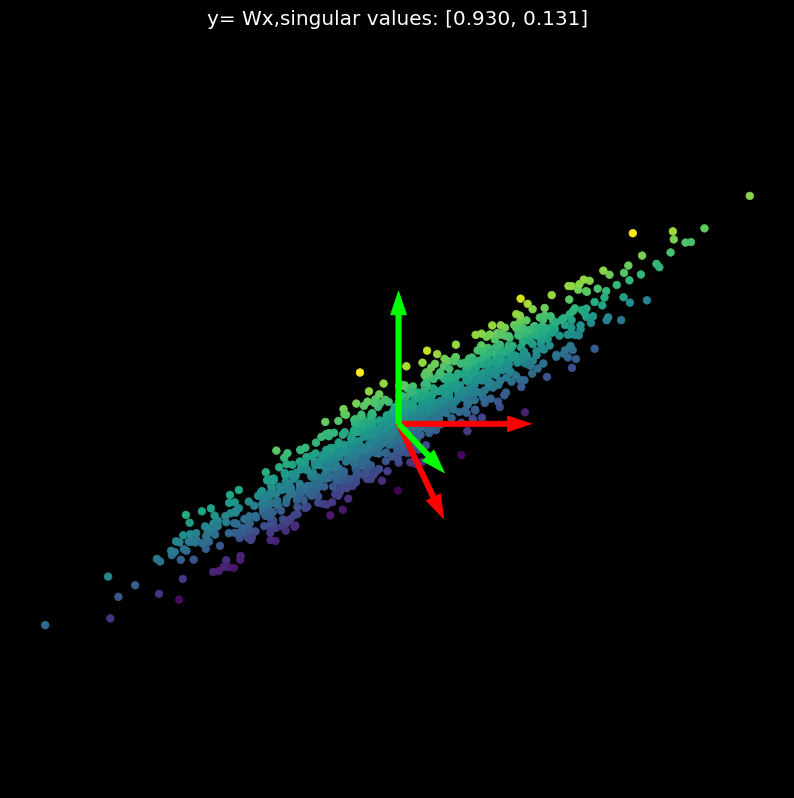

In [8]:
for i in range(10):
    #create a random matrix
    W = torch.randn(2,2).to(device)
    # transform points
    Y = X @ W.t()
    # compute singular values
    U, S, V = torch.svd(W)
    # plot transformed points
    show_scatterplot(Y, colors, title='y= Wx,singular values: [{:.3f}, {:.3f}]'.format(S[0], S[1]))
    # transform the basis
    new_OI = OI @ W
    # plot old and new basis
    plot_bases(OI)
    plot_bases(new_OI)

In [9]:
## Linear transformation with PyTorch

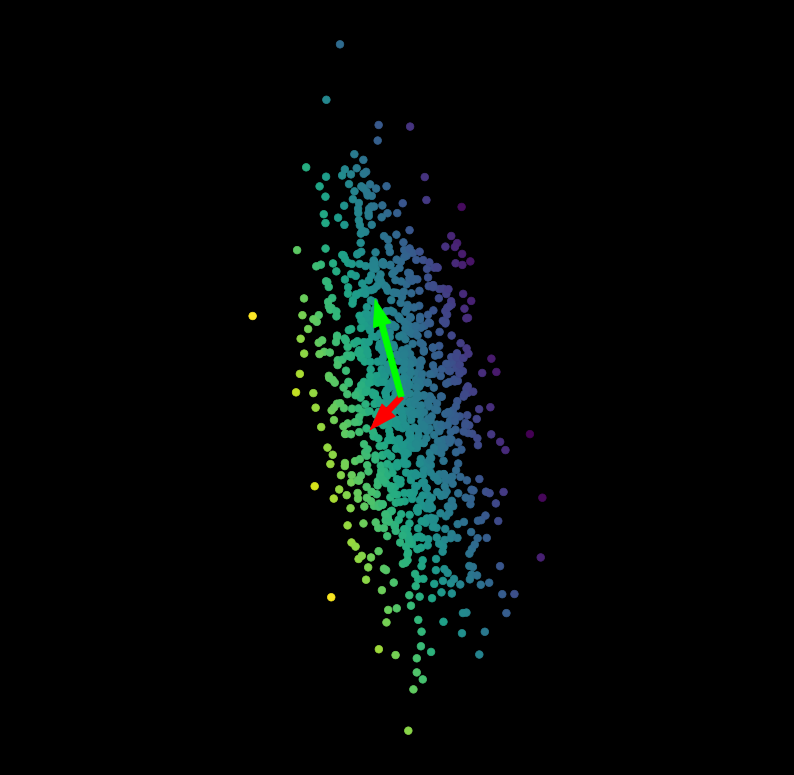

In [11]:
model = nn.Sequential(
    nn.Linear(2,2, bias=False)
)
model.to(device)
with torch.no_grad():
    Y = model(X)
    show_scatterplot(Y, colors)
    plot_bases(model(OI))

## Non-linear Transform: Map Points to a Square

- Linear transform can rotate, reflect, stretch and compress, but cannot curve
- We need non-linearities for this
- Can (approximately) map points to a square by first stretching out by a factor $s$, then squashing with a tanh function
$
   f(x)= \tanh \left(
  \left[ {\begin{array}{cc}
   s &amp; 0 \\
   0 &amp; s \\
  \end{array} } \right]  
  x
  \right)
$

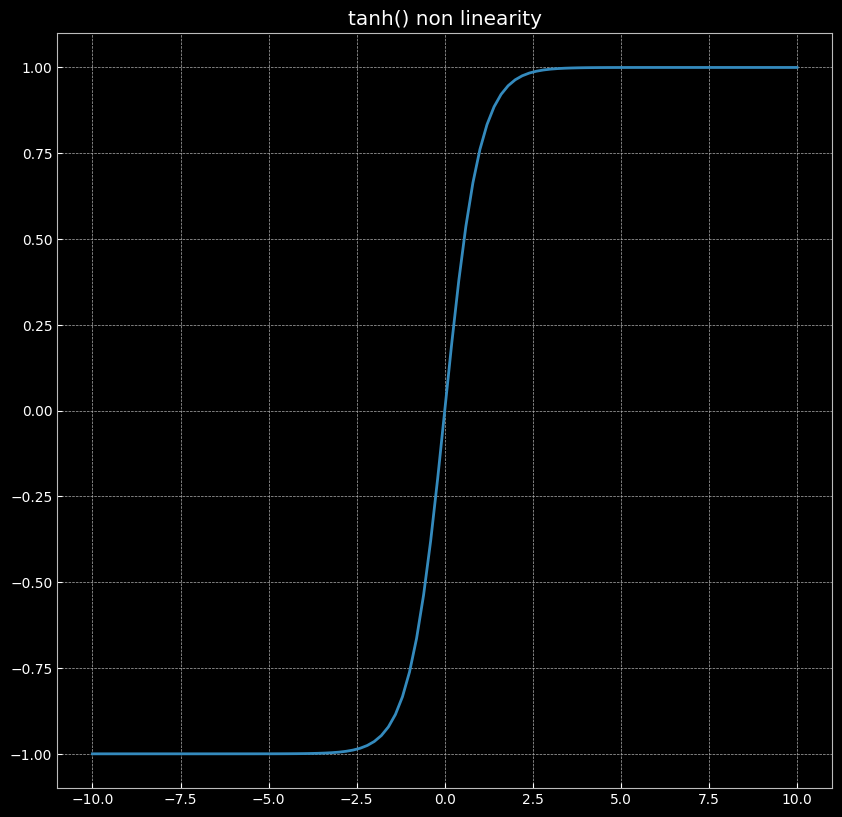

In [19]:
z = torch.linspace(-10, 10, 101)
s = torch.tanh(z)
plot(z.numpy(), s.numpy())
title('tanh() non linearity');

In [21]:
s

tensor([-1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -9.9999e-01, -9.9999e-01,
        -9.9999e-01, -9.9998e-01, -9.9997e-01, -9.9996e-01, -9.9994e-01,
        -9.9991e-01, -9.9986e-01, -9.9980e-01, -9.9970e-01, -9.9955e-01,
        -9.9933e-01, -9.9900e-01, -9.9851e-01, -9.9777e-01, -9.9668e-01,
        -9.9505e-01, -9.9263e-01, -9.8903e-01, -9.8367e-01, -9.7574e-01,
        -9.6403e-01, -9.4681e-01, -9.2167e-01, -8.8535e-01, -8.3365e-01,
        -7.6159e-01, -6.6404e-01, -5.3705e-01, -3.7995e-01, -1.9738e-01,
         1.4901e-07,  1.9738e-01,  3.7995e-01,  5.3705e-01,  6.6404e-01,
         7.6159e-01,  8.3365e-01,  8.8535e-01,  9.2167e-01,  9.4681e-01,
         9.6403e-01,  9.7574e-01,  9.8367e-01,  9.8903e-01,  9.9263e-01,
         9.9505e-01,  9.9668e-01,  9.9777e-01,  9.9

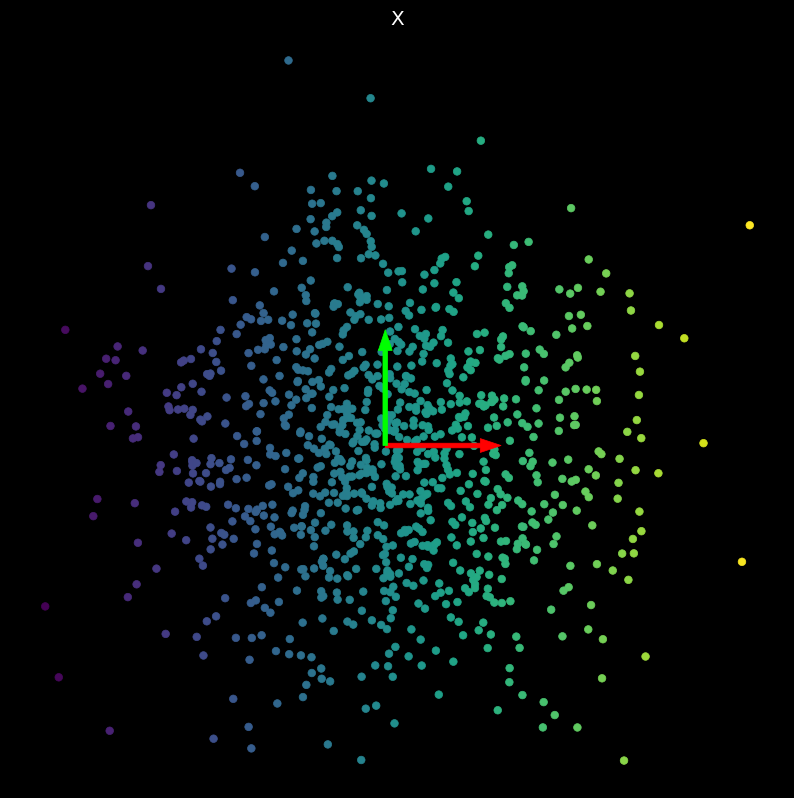

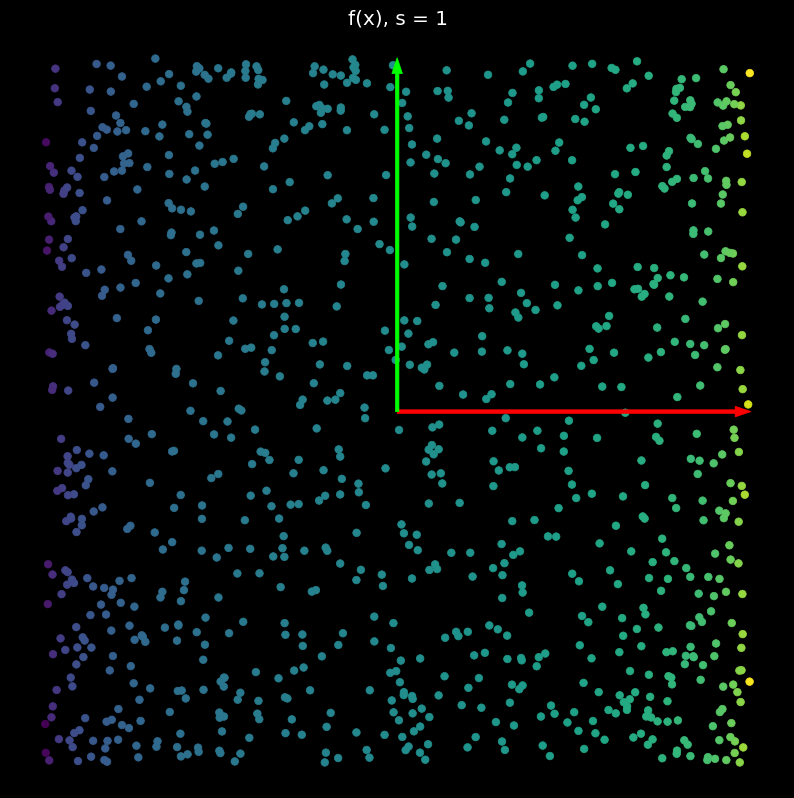

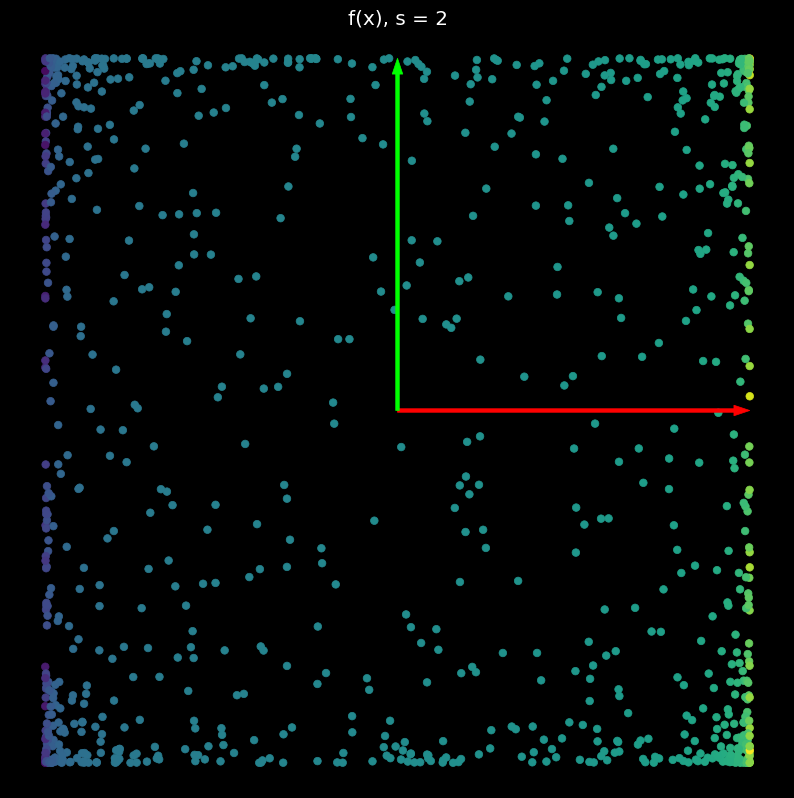

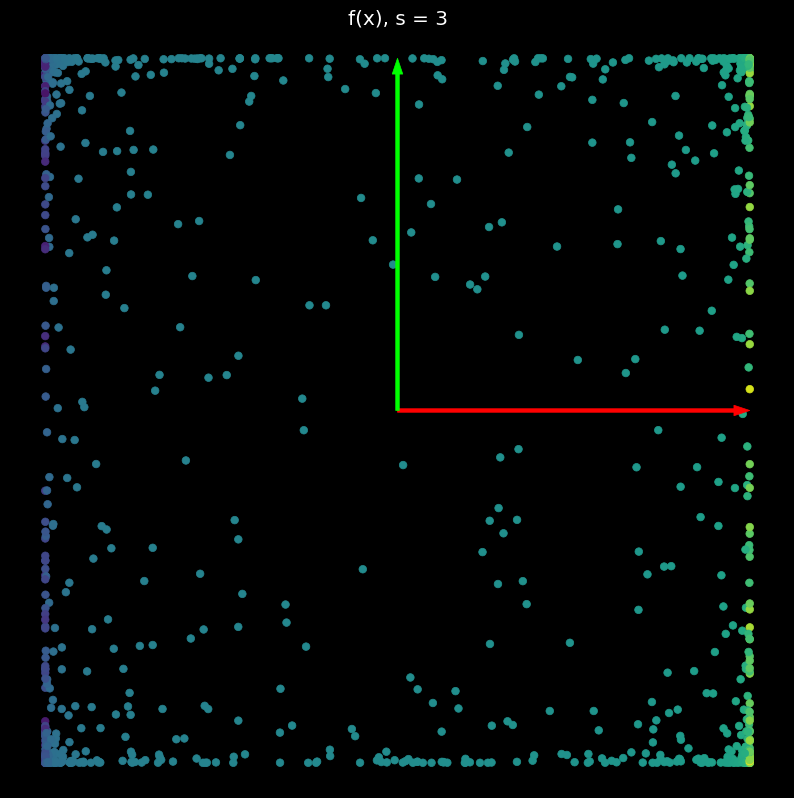

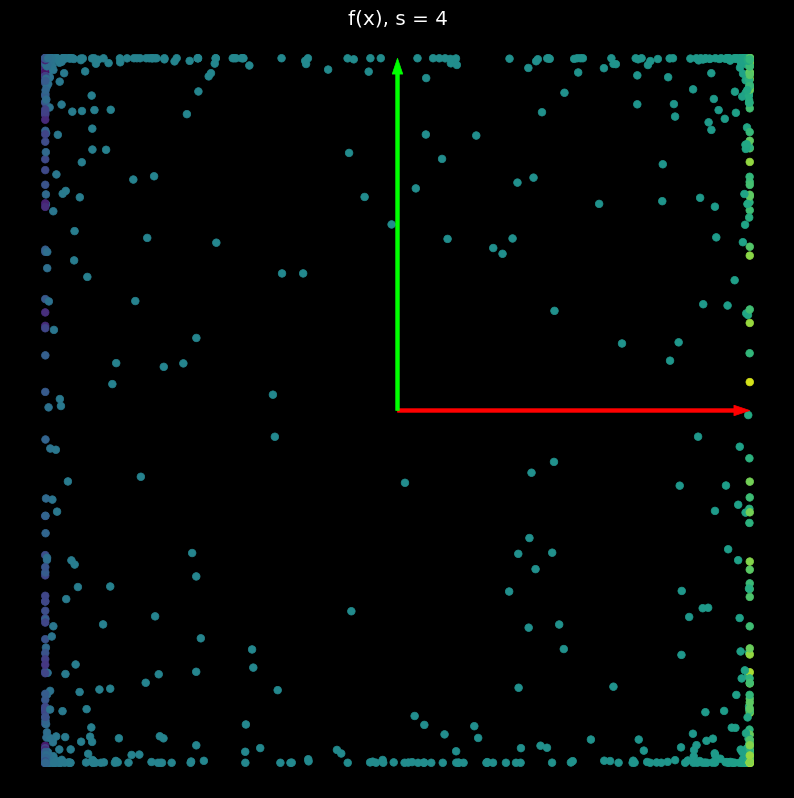

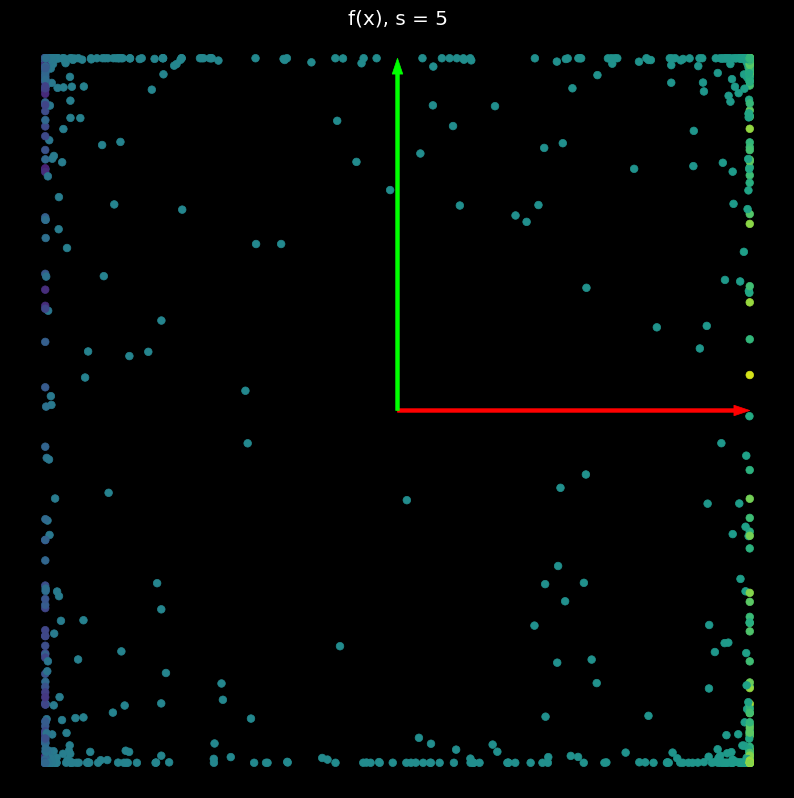

In [23]:
show_scatterplot(X, colors, title='X')
plot_bases(OI)

model = nn.Sequential(
    nn.Linear(2,2, bias=False),
    nn.Tanh()
)
model.to(device)

for s in range(1, 6):
    W = s * torch.eye(2)
    model[0].weight.data.copy_(W)
    Y = model(X).data
    show_scatterplot(Y, colors, title=f'f(x), s = {s}')
    plot_bases(OI, width =0.01)

## Visualize Functions Represented by Random Neural Networks

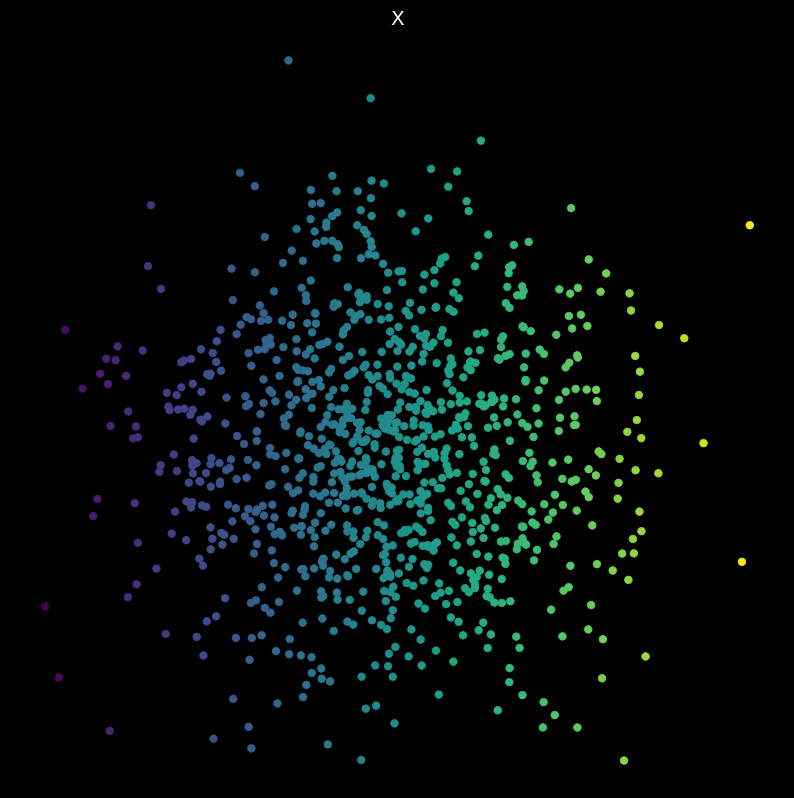

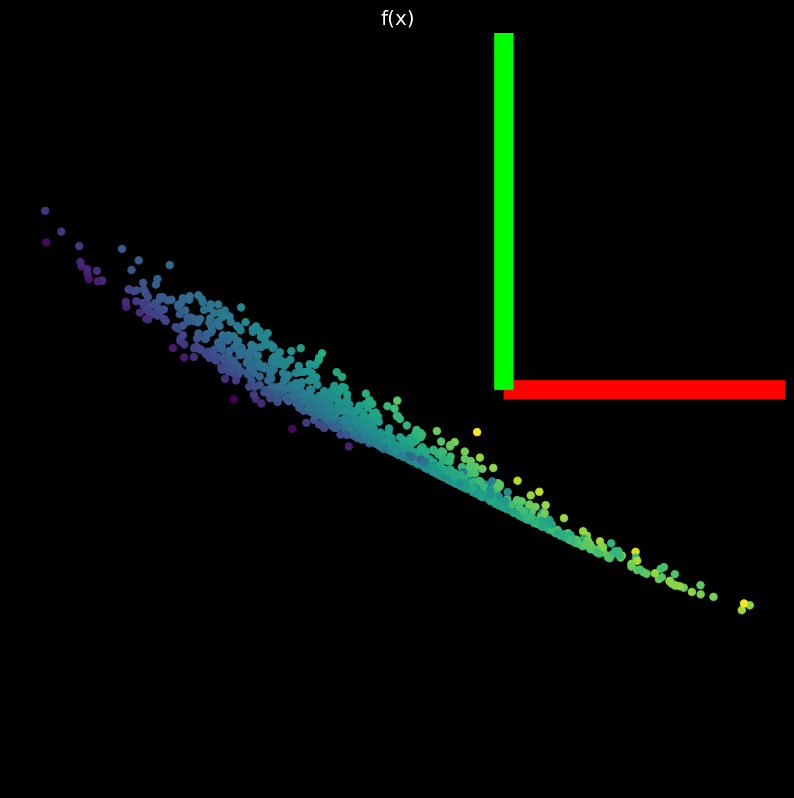

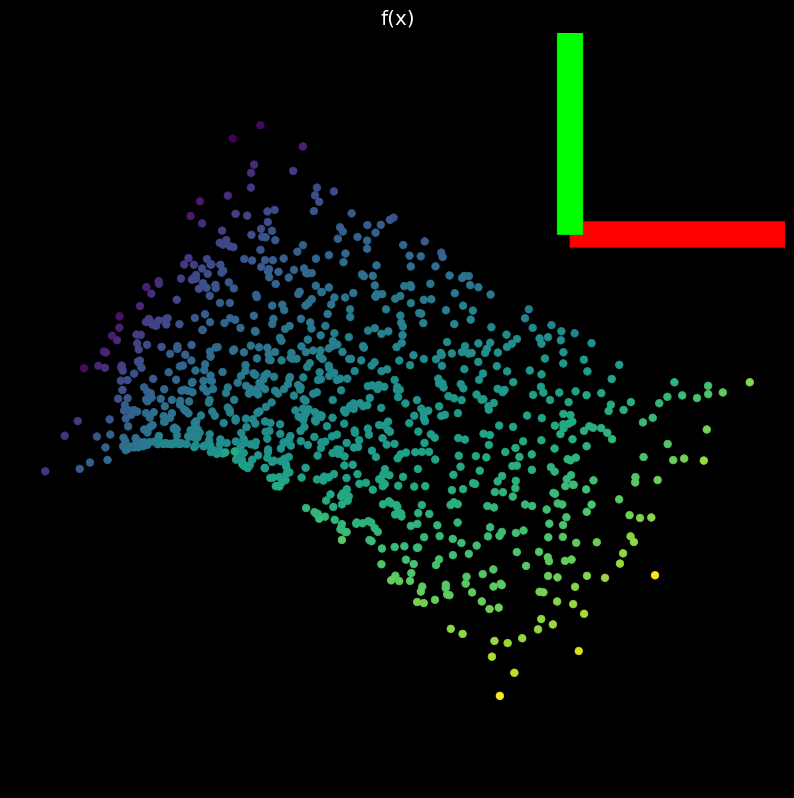

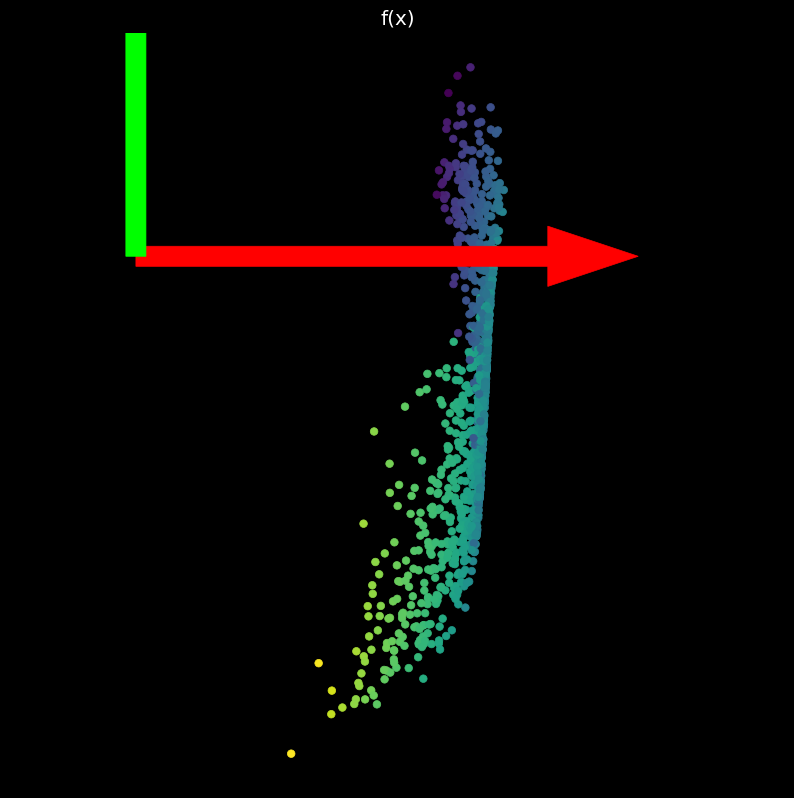

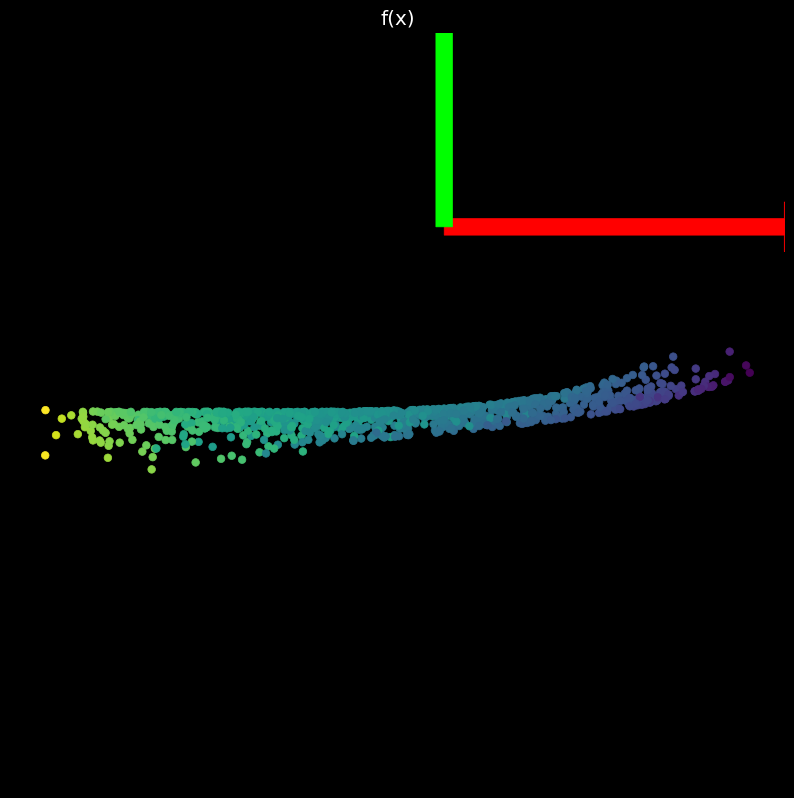

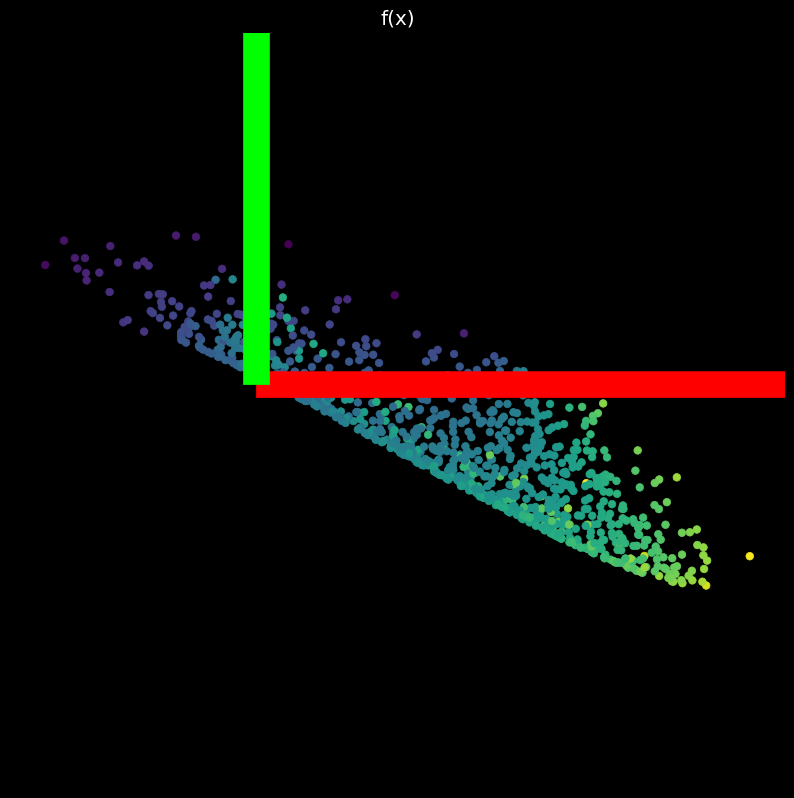

In [24]:
show_scatterplot(X, colors, title= 'X')
n_hidden = 5

NL = nn.Tanh()

for i in range(5):
    # create 1-layer neural networks with random weights
    model = nn.Sequential(
        nn.Linear(2, n_hidden),
        NL,
        nn.Linear(n_hidden, 2)
    )
    model.to(device)
    with torch.no_grad():
        Y = model(X)

    show_scatterplot(Y, colors, title='f(x)')
    plot_bases(OI)

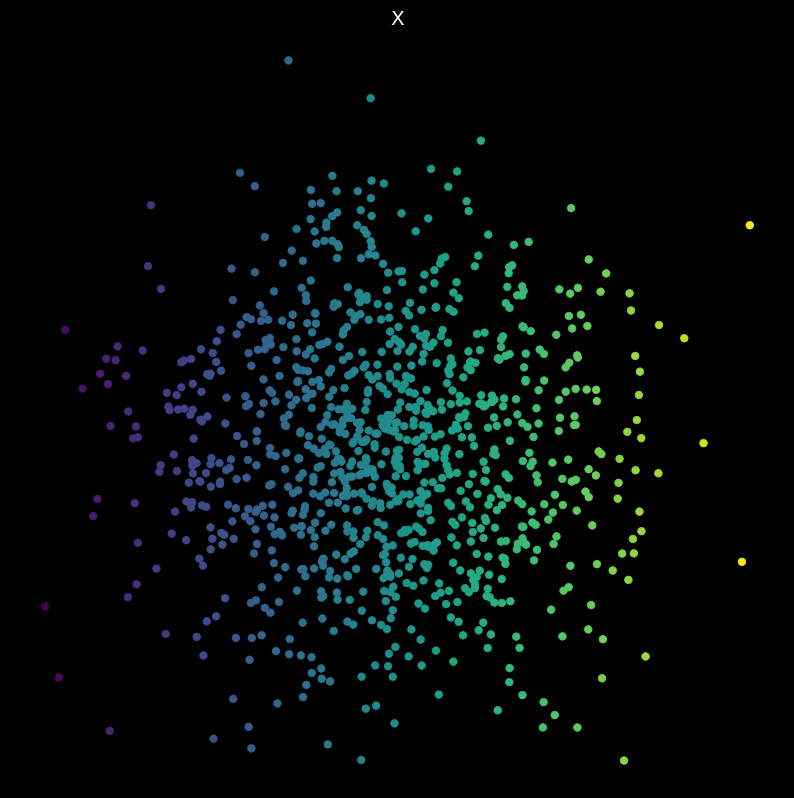

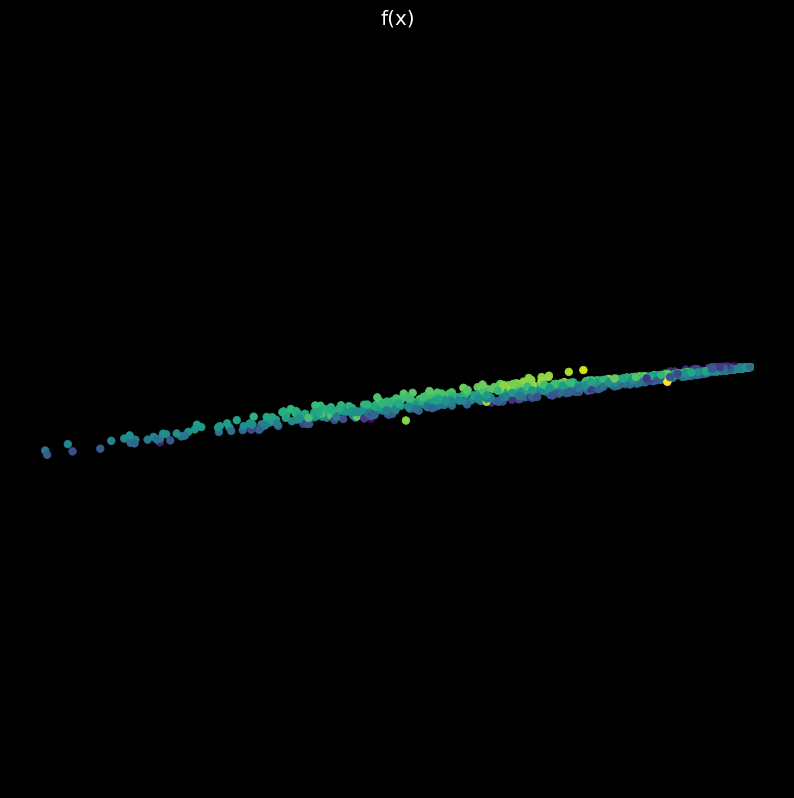

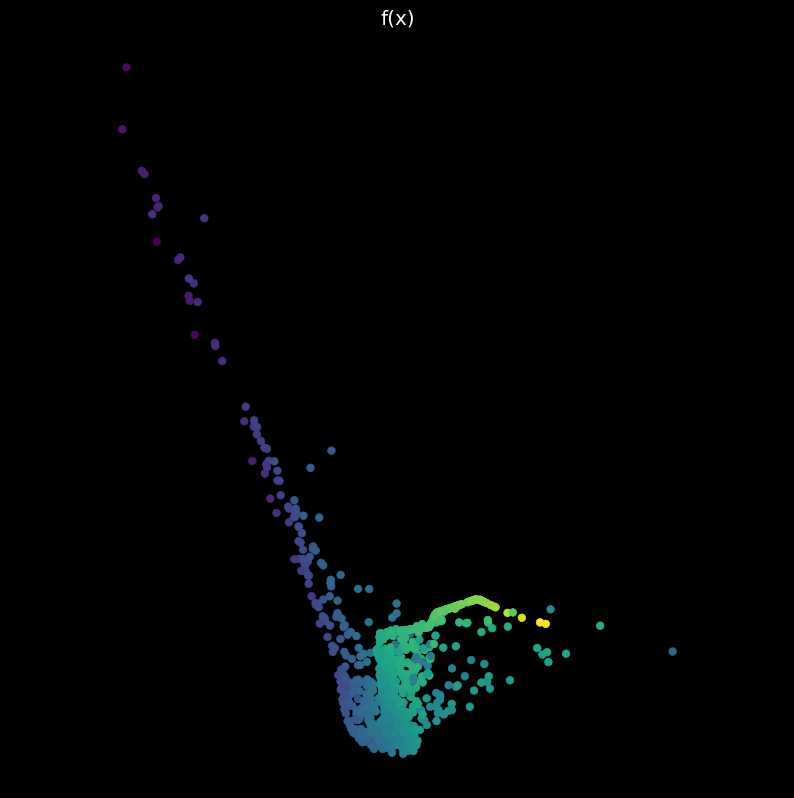

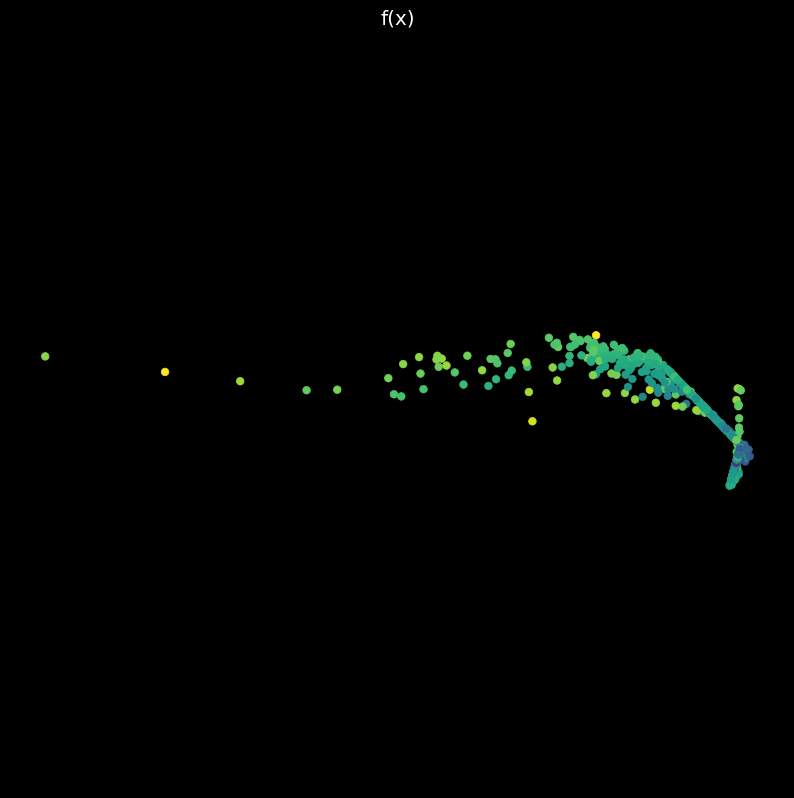

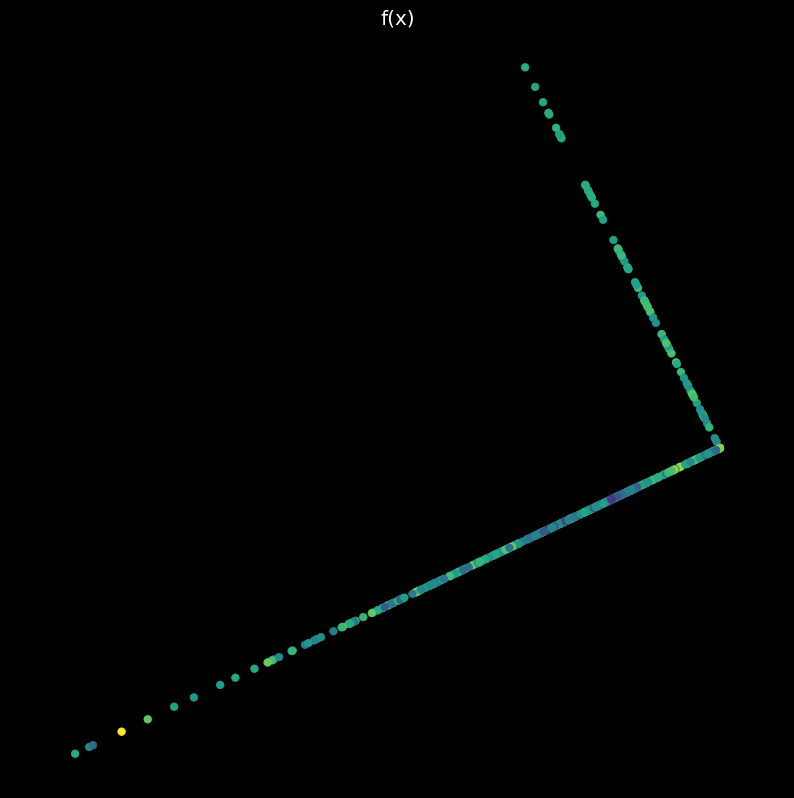

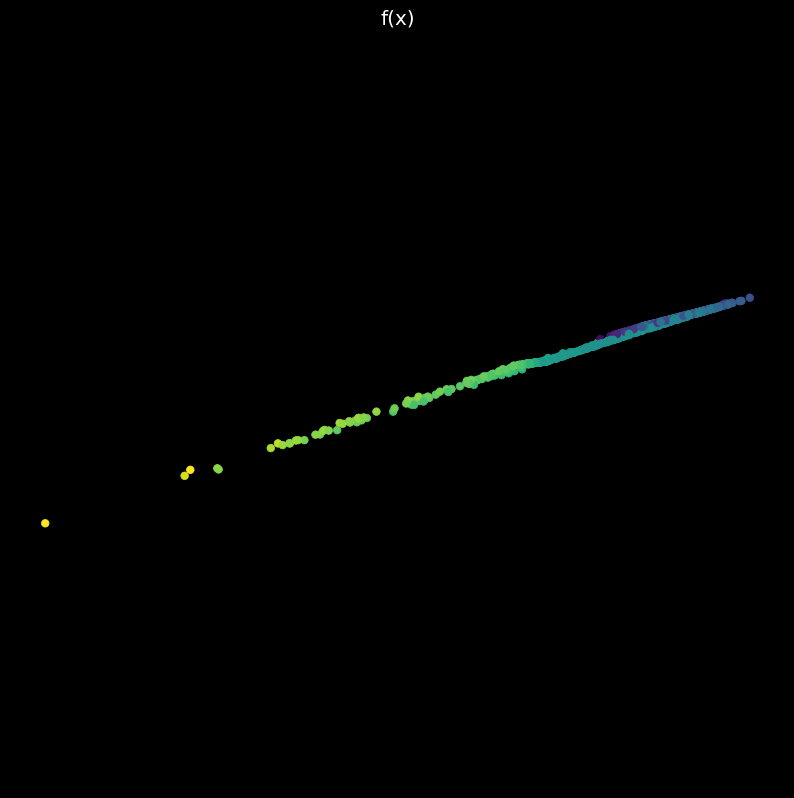

In [25]:
# deeper network with random weights

show_scatterplot(X, colors, title='X')
n_hidden = 5

NL = nn.ReLU()

for i in range(5):
    model = nn.Sequential(
        nn.Linear(2, n_hidden),
        NL,
        nn.Linear(n_hidden, n_hidden),
        NL,
        nn.Linear(n_hidden, n_hidden),
        NL,
        nn.Linear(n_hidden, n_hidden),
        NL,
        nn.Linear(n_hidden, 2)
    )
    model.to(device)
    with torch.no_grad():
        Y = model(X).detach()
    show_scatterplot(Y, colors, title='f(x)')